# Data Analysis
This notebook is used to analyze the data collected from live runs. It includes various visualizations and statistical analyses to understand the performance of the runner

## TOC:
### [Feature Engineering](#tests-for-feature-engineering)
### [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
* [Performance from Specific Runs](#performance-from-specific-runs)
* [Pearsons Correlation Matrix for Specific Runs](#pearsons-correlation-matrix-for-specific-runs)
* [Variance Inflation Factor (VIF)](#variance-inflation-factor-vif)
* [Rolling Windowed Correlation](#rolling-windowed-correlation)
* [Multivariate Regression](#multivariate-regression)

In [2]:
from utilis.helper import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
output_folder = extract_global_json("output_folder")


## Cleaning data
This section is used to clean the data before analysis. It includes removing unnecessary columns, handling missing values, and converting data types.

In [58]:
# Show all rows
pd.set_option('display.max_rows', None)

# Show all columns
pd.set_option('display.max_columns', None)

# Optional: widen the display to avoid line wrapping
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)  # or a large int, e.g. 200

# folder = "2025-07-05_12-32"
# folder = "2025-07-22_19-40"
# folder = "2025-07-25_19-53"
# folder = "2025-07-27_10-27"
# folder = "2025-07-29_20-03"
# folder = "2025-07-31_20-07"
# folder = "2025-08-02_18-02"
# folder = "2025-08-04_20-02"
folder = "2025-08-06_20-14"
# loop through all folders in the output folder
for folder_name in os.listdir(output_folder):
    if folder in folder_name:
        # first read the csv file
        csv_file_path = os.path.join(output_folder, folder_name, f"{folder_name}_streams.csv")
        json_file_path = os.path.join(output_folder, folder_name, f"{folder_name}_overall.json")

        break
# read the csv file
data = pd.read_csv(csv_file_path)
overall_data = extract_json(json_file_path)

In [83]:
data["heartrate_bps"] = data["heartrate_bpm"] / 60  # convert bps to bpm
data["cadence_rps"] = data["cadence_rpm"] / 60  # convert rpm to rps

# add moving average smoothing to the data
# data["heartrate_smooth_bpm"] = data["heartrate_bpm"].rolling(window=10, min_periods=1).mean()
data["heartrate_smooth_bps"] = data["heartrate_bps"].rolling(window=10, min_periods=1).mean()
data["velocity_smooth_mps"] = data["velocity_mps"].rolling(window=10, min_periods=1).mean()
data["altitude_smooth_m"] = data["altitude_m"].rolling(window=10, min_periods=1).mean()
data["headwind_smooth_mps"] = data["headwind_mps"].rolling(window=10, min_periods=1).mean()
data["crosswind_smooth_mps"] = data["crosswind_mps"].rolling(window=10, min_periods=1).mean()
data["stride_length_smooth_m"] = data["stride_length_m"].rolling(window=10, min_periods=1).mean()

# add diff columns
data["diff_heartrate_smooth_bps2"] = data["heartrate_smooth_bps"].diff().fillna(0)
data["diff_heartrate_smooth_shift_bps2"] = data["heartrate_smooth_bps"].diff().shift(5).fillna(0)
data["diff_altitude_smooth_mps"] = data["altitude_smooth_m"].diff().fillna(0)
data["diff_velocity_smooth_mps2"] = data["velocity_smooth_mps"].diff().fillna(0)


# change diff_altitude_m


data.dropna(inplace=True)

# Exploratory Data Analysis (EDA)
This section will include various exploratory data analysis techniques to understand the data better, including visualizations and statistical summaries.

### Performance from Specific Runs
This section will focus on analyzing the performance from specific runs, including visualizations and statistical summaries.

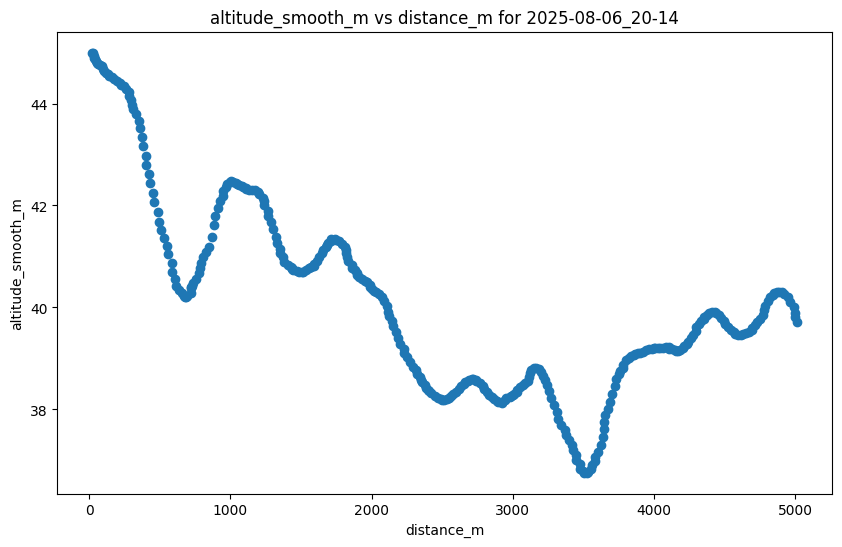

In [97]:
# x = "altitude_m"
# x = "altitude_change_m"
# y = "pace_efficiency"
# y = "stride_length_m"
# y = "heartrate_bpm"
# y = "heartrate_smooth_bpm"
# y = "diff_heartrate_smooth_bpm"
# y = "headwind_smooth_mps"
# y = "headwind_mps"
# y = "stride_length_m"
# y = "stride_length_smooth_m"
# y = "diff_heartrate_bpm"
# y = "cadence_rpm"

# x = "cadence_rpm"
# x = "grade_percent"
# x = "time_s"
x = "distance_m"
y = "altitude_smooth_m"
# y = "altitude_m"

# x_list = []
# y_list = []

# get the time and cadence columns
x_data = data[x]
y_data = data[y]

# plot this data
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label=folder_name)
# plt.plot(x_data, y_data, label=folder_name)
plt.xlabel(x)
plt.ylabel(y)
plt.title(f"{y} vs {x} for {folder_name}")
plt.show()

### Pearsons Correlation Matrix for Specific Runs

In [ ]:
# Exploratory Data Analysis (EDA)
analyzable_columns = [
    "time_s",
    "pace_efficiency",
    "heartrate_bps",
    "diff_heartrate_bps",
    "diff_heartrate_shift_bps",
    "velocity_mps", 
    "diff_velocity_mps2",
    "diff_velocity_shift_mps2",
    "altitude_m",
    "diff_altitude_m",
    "stride_length_m", 
    "cadence_rpm", 
    "headwind_mps", 
    "crosswind_mps", 
    # "athletedir_degree", 
    # "relative_winddir_degree", 
    "grade_percent"
]
corr_matrix = data[analyzable_columns].corr()

# Show correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1)
for i in range(len(analyzable_columns)):
    for j in range(len(analyzable_columns)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="black")
plt.colorbar()
# plt.xticks(range(len(analyzable_columns)), analyzable_columns, rotation=30)
plt.xticks(range(len(analyzable_columns)), analyzable_columns, rotation=90)
plt.yticks(range(len(analyzable_columns)), analyzable_columns)
plt.title(f"Pearson Correlation Matrix for {folder_name}")
plt.tight_layout()
plt.show()
# data

### Variance Inflation Factor (VIF)
This section will calculate the Variance Inflation Factor (VIF) for the features in the dataset to check for multicollinearity.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
from statsmodels.api import add_constant

# only look at numerical columns for VIF
data_numerical = data.select_dtypes(include=[float, int])

# Assuming X is your design matrix with a constant added
X = add_constant(data_numerical)  # df = your feature DataFrame
# X = add_constant(data_numerical.drop(columns=["pace_efficiency"]))  # df = your feature DataFrame
vif = pd.DataFrame()
vif["feature"] = X.columns
# data_numerical
vif["VIF"] = [int(variance_inflation_factor(X.values, i)) for i in range(X.shape[1])]
print(vif)

### Rolling Windowed Correlation

In [ ]:
# Assuming df has columns 'heart_rate' and 'headwind'
window_size = 30  # e.g., 60 time steps
# rolling_corr = data['heartrate_bpm'].rolling(window=window_size).corr(data['distance_m'])
# rolling_corr = data['heartrate_bpm'].rolling(window=window_size).corr(data['headwind_mps'])
# rolling_corr = data['heartrate_bpm'].rolling(window=window_size).corr(data['time_s'])
rolling_corr = data['heartrate_bps'].rolling(window=window_size).corr(data['altitude_m'])
rolling_corr.plot(title="Rolling Correlation: Heart Rate vs Headwind", figsize=(12, 6), ylabel='Correlation Coefficient', xlabel='Time Steps')

## Model Analysis
This section will include various models to predict the differential of heart rate and speed based on the features. It will include different regression models and their performance metrics.

### Multivariate Regression

In [90]:
from statsmodels.api import OLS, add_constant

analyzable_columns = [
    # "time_s",
    "distance_m",
    "pace_efficiency",
    "heartrate_smooth_bps",
    # "heartrate_bpm",
    # "altitude_m",
    "altitude_smooth_m",
    # "diff_altitude_smooth_m",
    "stride_length_m", 
    "velocity_smooth_mps", 
    # "velocity_mps", 
    # "cadence_rpm", 
    # "headwind_mps", 
    "headwind_smooth_mps", 
    # "crosswind_mps", 
    "crosswind_smooth_mps", 
    # "athletedir_degree", 
    # "relative_winddir_degree", 
    "grade_percent"
]

# test exponential regression

# x = data["grade_percent"]
x = data[analyzable_columns]
# y = data['pace_efficiency']
# y = data['diff_pace_efficiency']
y = data['diff_velocity_smooth_mps2']
# y = data['acceleration_shift_mps2']
# y = data['diff_heartrate_bpm']
# y = data['diff_heartrate_smooth_bpm']
# y = data["diff_heartrate_smooth_shift_bpm"]
X = add_constant(x)

model = OLS(y, X).fit()
print(model.summary())


                                OLS Regression Results                               
Dep. Variable:     diff_velocity_smooth_mps2   R-squared:                       0.536
Model:                                   OLS   Adj. R-squared:                  0.523
Method:                        Least Squares   F-statistic:                     42.55
Date:                       Fri, 08 Aug 2025   Prob (F-statistic):           3.04e-50
Time:                               16:24:08   Log-Likelihood:                 569.92
No. Observations:                        342   AIC:                            -1120.
Df Residuals:                            332   BIC:                            -1081.
Df Model:                                  9                                         
Covariance Type:                   nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

0.6176109802357725


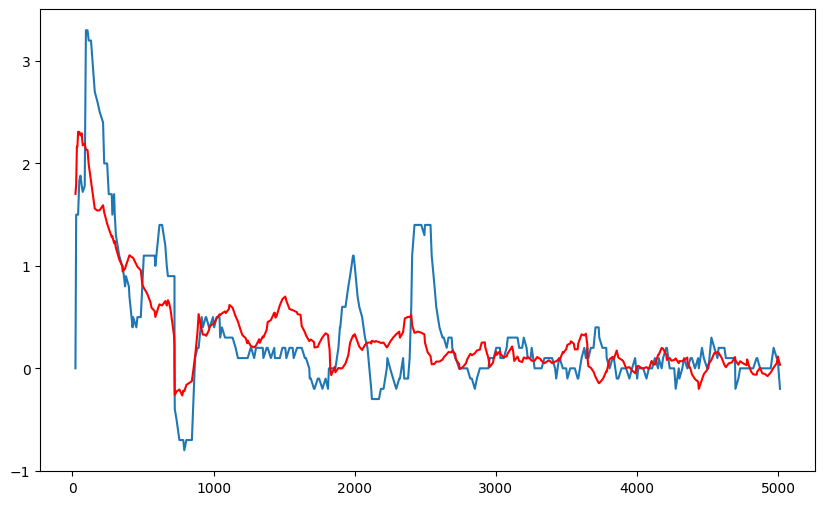

In [79]:
# Elastic Net Regression
from sklearn.linear_model import ElasticNet

# Define the model
model = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000)  # Adjust alpha and l1_ratio as needed
# Fit the model
model.fit(x, y)
# predict pace efficiency based on the model
y_pred = model.predict(x)

print(model.score(x, y))
# # Plot the data and the fitted line
plt.figure(figsize=(10, 6))
plt.plot(data["distance_m"], y, label='Data Points')
# plt.scatter(data["distance_m"], y, label='Data Points')
plt.plot(data["distance_m"], y_pred, color='red', label='Fitted Line')

In [ ]:
# predict pace efficiency based on the model
y_pred = model.predict(X)
# # Plot the data and the fitted line
plt.figure(figsize=(10, 6))
plt.plot(data["distance_m"], y, label='Data Points')
# plt.scatter(data["distance_m"], y, label='Data Points')
plt.plot(data["distance_m"], y_pred, color='red', label='Fitted Line')